In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
%cd '/content/drive/My Drive/Fruit_States_RnC'

/content/drive/.shortcut-targets-by-id/1bNsY41NQ7yt_0gKqP3j-2gJ1pdli4usp/Fruit_States_RnC


In [20]:
import argparse
import os
import sys
import logging
import torch
import time
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
from model_fruits import Encoder, model_dict
from dataset_fruits import *
from utils_fruits import *
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [21]:
def parse_option(args=None):
    parser = argparse.ArgumentParser('argument for training')

    parser.add_argument('--print_freq', type=int, default=10, help='print frequency')
    parser.add_argument('--save_freq', type=int, default=50, help='save frequency')

    parser.add_argument('--batch_size', type=int, default=64, help='batch_size')
    parser.add_argument('--num_workers', type=int, default=16, help='num of workers to use')
    parser.add_argument('--epochs', type=int, default=100, help='number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=0.05, help='learning rate')
    parser.add_argument('--lr_decay_rate', type=float, default=0.2, help='decay rate for learning rate')
    parser.add_argument('--weight_decay', type=float, default=0, help='weight decay')
    parser.add_argument('--momentum', type=float, default=0.9, help='momentum')
    parser.add_argument('--trial', type=str, default='0', help='id for recording multiple runs')

    parser.add_argument('--data_folder', type=str, default='./data_fruits', help='path to custom dataset')
    parser.add_argument('--dataset', type=str, default='FruitsDataset', choices=['FruitsDataset', 'FruitsDatasetV2', 'FruitsDatasetRGB'], help='dataset')
    parser.add_argument('--model', type=str, default='resnet18', choices=['resnet18', 'resnet50'])
    parser.add_argument('--resume', type=str, default='', help='resume ckpt path')
    parser.add_argument('--aug', type=str, default='crop,flip,color,grayscale,rotate', help='augmentations')

    parser.add_argument('--ckpt', type=str, default='', help='path to the trained encoder')

    if args is None:
        args = []
    opt = parser.parse_args(args=args)

    return opt

def set_loader(opt, split='', num_channel=8):
    transforms = get_transforms(split='val', aug=opt.aug, num_channel=num_channel)

    dataset = globals()[opt.dataset](
        data_folder=opt.data_folder,
        transform=transforms,
        split=split
    )

    print(f'Set size: {dataset.__len__()}\t')

    loader = torch.utils.data.DataLoader(
        dataset, batch_size=opt.batch_size, shuffle=False, num_workers=opt.num_workers, pin_memory=True
    )

    return loader

In [46]:
# def predict(val_loader, model, regressor, split = ''):
#     model.eval()
#     regressor.eval()

#     predictions = []

#     with torch.no_grad():
#         for idx, (images, labels) in enumerate(val_loader):
#             images = images

#             features = model(images)
#             output = regressor(features)

#             predictions.append(output.cpu())

#     predictions = torch.cat(predictions, dim=0)
#     return predictions.detach().numpy()

def extract_features(loader, model, split = ''):
    model.eval()

    feature_store = []
    with torch.no_grad():
        for idx, (images, labels) in enumerate(loader):
            images = images

            features = model(images)

            feature_store.append(features.cpu())

    feature_store = torch.cat(feature_store, dim=0)
    return feature_store.detach().numpy()

def load_features(args=None, data_opt='', split='', load_folder='save/'):
    opt = parse_option(args)

    if data_opt == 'rgb':
      result_folder = 'FruitsDatasetRGB_models'
      model_name = 'RnC_FruitsDatasetRGB_resnet18_ep_400_lr_0.5_d_0.9_wd_0.0001_mmt_0.9_bsz_256_aug_crop,flip,rotate_temp_2.0_label_l1_feature_l2_trial_0'
      regressor_name = 'Regressor_FruitsDatasetRGB_ep_200_lr_0.001_d_0.8_wd_0.0_mmt_0.9_bsz_256_trial_0_best.pth'
      opt.dataset = 'FruitsDatasetRGB'
      opt.data_folder = 'data_fruits_v2'
      y = np.load('data_fruits_v2/y_avsb_' + split + '.npy')
      num_channel = 3
    elif data_opt == 'v2':
      result_folder = 'FruitsDatasetV2_models'
      model_name = 'RnC_FruitsDatasetV2_resnet18_ep_400_lr_0.5_d_0.9_wd_0.0001_mmt_0.9_bsz_256_aug_crop,flip,rotate_temp_2.0_label_l1_feature_l2_trial_0'
      regressor_name = 'Regressor_FruitsDatasetV2_ep_200_lr_0.001_d_0.8_wd_0.0_mmt_0.9_bsz_256_trial_0_best.pth'
      opt.dataset = 'FruitsDatasetV2'
      opt.data_folder = 'data_fruits_v2'
      num_channel = 8
      y = np.load('data_fruits_v2/y_avsb_' + split + '.npy')
    else:
      result_folder = 'FruitsDataset_models'
      model_name = 'RnC_FruitsDataset_resnet18_ep_400_lr_0.5_d_0.1_wd_0.0001_mmt_0.9_bsz_256_aug_crop,flip,color,grayscale,rotate_temp_2_label_l1_feature_l2_trial_0'
      regressor_name = 'Regressor_FruitsDataset_ep_100_lr_0.05_d_0.2_wd_0_mmt_0.9_bsz_64_trial_0_best.pth'
      num_channel = 8
      opt.dataset = 'FruitsDataset'
      opt.data_folder = 'data_fruits'
      y = np.load('data_fruits/y_' + split + '.npy')

    # build data loader
    full_loader = set_loader(opt, split=split, num_channel=num_channel)

    # build model and criterion
    model = Encoder(name=opt.model, in_channel=num_channel)

    dim_in = model_dict[opt.model][1]
    dim_out = get_label_dim(opt.dataset)
    ckpt = torch.load(load_folder + result_folder + '/' + model_name + '/ckpt_epoch_350.pth', map_location='cpu')
    state_dict = ckpt['model']
    model.load_state_dict(state_dict)

    # regressor = torch.nn.Linear(dim_in, dim_out)
    # ckpt = torch.load('save/' + result_folder + '/' + model_name + '/' + regressor_name, map_location='cpu')
    # state_dict_regressor = ckpt['state_dict']
    # regressor.load_state_dict(state_dict_regressor)

    # predicted_y = predict(full_loader, model, regressor, split)

    features = extract_features(full_loader, model, split)

    return y, features

In [47]:
data_opt = 'v2'
y_test, features_test = load_features(data_opt=data_opt, split = 'test', load_folder= 'save/')
print(features_test.shape)

# y_train, features_train = load_features(data_opt=data_opt, split = 'train')
# print(features_train.shape)

Set size: 365	


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(365, 512)


In [48]:
pca_test = PCA(n_components=2)
features_test_reduced = pca_test.fit_transform(features_test)

# pca_train = PCA(n_components=2)
# features_train_reduced = pca_train.fit_transform(features_train)

In [49]:
# plt.figure(figsize=(10, 8))
# sc = plt.scatter(features_test_reduced[:, 0], features_test_reduced[:, 1], c=y_test, cmap='viridis', edgecolor='k', alpha=0.7)
# plt.colorbar(sc, label='Concentration Value')
# plt.title('RNC (Test Set)')
# plt.show()

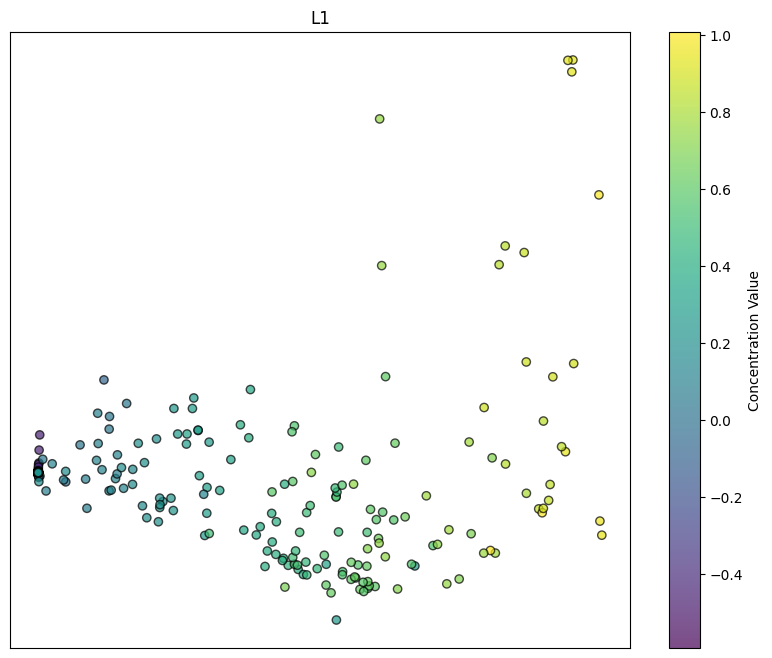

In [50]:
plt.figure(figsize=(10, 8))
# sc = plt.scatter(features_train_reduced[:, 0], features_train_reduced[:, 1], c=y_train, cmap='viridis', edgecolor='k', alpha=0.7)
sc = plt.scatter(features_test_reduced[:, 0], features_test_reduced[:, 1], c=y_test, cmap='viridis', edgecolor='k', alpha=0.7)
plt.colorbar(sc, label='Concentration Value')
plt.title('L1')
plt.xticks([])
plt.yticks([])
plt.show()

In [51]:
# data_opt = 'rgb'
# y_test, features_test = load_features(data_opt=data_opt, split = 'test', load_folder= 'save/')
# print(features_test.shape)

In [52]:
pca_test = PCA(n_components=2)
features_test_reduced = pca_test.fit_transform(features_test)

In [53]:
# # from sklearn.preprocessing import normalize

# plt.figure(figsize=(10, 8))
# # sc = plt.scatter(features_train_reduced[:, 0], features_train_reduced[:, 1], c=y_train, cmap='viridis', edgecolor='k', alpha=0.7)
# sc = plt.scatter(features_test_reduced[:, 0], features_test_reduced[:, 1], c=y_test, cmap='viridis', edgecolor='k', alpha=0.7)
# plt.colorbar(sc, label='Concentration Value')
# plt.title('L1')
# plt.xticks([])
# plt.yticks([])
# plt.show()

Set size: 365	


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(365, 512)


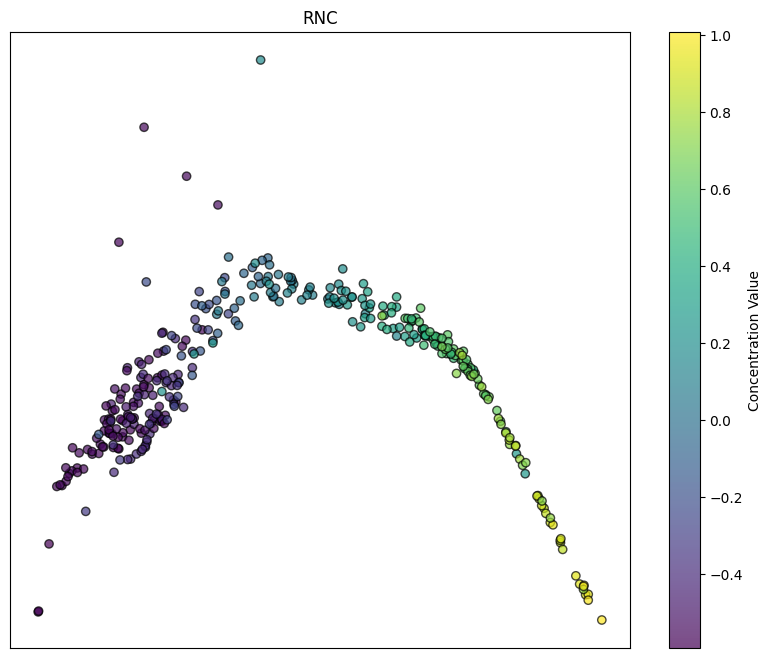

In [54]:
data_opt = 'v2'
y_test, features_test = load_features(data_opt=data_opt, split = 'test', load_folder= 'save_final/')
print(features_test.shape)

pca_test = PCA(n_components=2)
features_test_reduced = pca_test.fit_transform(features_test)

plt.figure(figsize=(10, 8))
# sc = plt.scatter(features_train_reduced[:, 0], features_train_reduced[:, 1], c=y_train, cmap='viridis', edgecolor='k', alpha=0.7)
sc = plt.scatter(features_test_reduced[:, 0], features_test_reduced[:, 1], c=y_test, cmap='viridis', edgecolor='k', alpha=0.7)
plt.colorbar(sc, label='Concentration Value')
plt.title('RNC')
plt.xticks([])
plt.yticks([])
plt.show()

In [55]:
# data_opt = 'rgb'
# y_test, features_test = load_features(data_opt=data_opt, split = 'test', load_folder= 'save_final/')
# print(features_test.shape)

# pca_test = PCA(n_components=2)
# features_test_reduced = pca_test.fit_transform(features_test)

# plt.figure(figsize=(10, 8))
# # sc = plt.scatter(features_train_reduced[:, 0], features_train_reduced[:, 1], c=y_train, cmap='viridis', edgecolor='k', alpha=0.7)
# sc = plt.scatter(features_test_reduced[:, 0], features_test_reduced[:, 1], c=y_test, cmap='viridis', edgecolor='k', alpha=0.7)
# plt.colorbar(sc, label='Concentration Value')
# plt.title('RNC')
# plt.xticks([])
# plt.yticks([])
# plt.show()

# Plotting Learned Representation using t-SNE

In [56]:
# tsne = TSNE(n_components=2, perplexity=30, n_iter=3000)
# features_tsne = tsne.fit_transform(features_train)

In [57]:
# plt.figure(figsize=(12, 10))
# sc = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=y_train, cmap='viridis', edgecolor='k', alpha=0.7)
# plt.colorbar(sc, label='Concentration Value')
# plt.title('RNC')
# plt.xticks([])
# plt.yticks([])
# plt.show()